In [0]:
import tensorflow as tf
import tensorflow.keras as keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def import_and_authenticate():
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def get_dataset(link, drive):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('temp.csv')  
  dataset = pd.read_csv('temp.csv')
  return dataset

def activate_drive():
  from google.colab import drive
  drive.mount('/content/gdrive')

import matplotlib.pyplot as plt
def plot_process(history, name):
  plt.figure(figsize=(15,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['mean_absolute_error'])
  plt.plot(history.history['val_mean_absolute_error'])
  plt.title('model Description')
  plt.ylabel('Error')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'test_loss','train_mean_absolute_error','test_mean_absolute_error'], loc='upper left')
  plt.show()
  plt.savefig(name)

In [0]:
drive = import_and_authenticate()
train = get_dataset('https://drive.google.com/open?id=1r895ehmjNucPkcfasZgVNKFJGjKA2AKd', drive) 
#train = get_dataset('https://drive.google.com/open?id=1Y2nkm8s3FAa4feA4m_ofjeiGf6VoyQ2f',drive) # Zero-filled


In [0]:
# Dropping универсальный товар & cleaning all except akbar 
train = train[train['item_id'] != 5037].copy()
train = train[train['shop_id']==5].copy()

In [154]:
train.head()

,Unnamed: 0,week,day_of_week,item_id,item_cost,shop_id,item_quantity
0,0,0,5,255,360.0,5,1.0
1,1,0,5,292,1400.0,5,1.0
2,2,0,5,515,170.0,5,1.0
3,3,0,5,549,400.0,5,1.0
4,4,0,5,664,3100.0,5,1.0


In [0]:
## Dropping trash in dataset
train = train.drop(columns = train.columns.values[0])

In [156]:
train.head()

,week,day_of_week,item_id,item_cost,shop_id,item_quantity
0,0,5,255,360.0,5,1.0
1,0,5,292,1400.0,5,1.0
2,0,5,515,170.0,5,1.0
3,0,5,549,400.0,5,1.0
4,0,5,664,3100.0,5,1.0


# Model preprocessing

## Splitting into Train & Test

In [0]:
def split_into_train_and_test(dataset):
  last_week = dataset['week'].max() # 19 week
  dataset = dataset[dataset['week'] != last_week]

  last_week = dataset['week'].max() # 18 week
  test = dataset[dataset['week'] == last_week].copy() # 18 week
  train = dataset[dataset['week'] != last_week] # All before 18 week
  return train,test

train, test = split_into_train_and_test(train)

In [158]:
print(f"Last week of test: {test['week'].max()}\nLast week of train: {train['week'].max()}.")

Last week of test: 18
Last week of train: 17.


## Splitting into X & y

In [0]:
def split(dataset):
  return dataset[dataset.columns.values[:-1]].values, np.reshape(dataset[dataset.columns.values[-1]].values,(-1,1))
X_train, y_train = split(train)
X_test, y_test = split(test)


## Scaling for Neural Network

In [0]:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
y_scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)

In [161]:
X_scaler.fit(X_train)
y_scaler.fit(y_train)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [0]:
X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)

In [0]:
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

## Model building

In [164]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, input_shape = (X_train_scaled.shape[1],), use_bias=False))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dense(15,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.LeakyReLU(alpha=0.2))
model.add(keras.layers.Dense(10,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dense(10,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.LeakyReLU(alpha=0.2))
model.add(keras.layers.Dense(5,use_bias = True))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.LeakyReLU(alpha=0.2))
model.add(keras.layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                100       
_________________________________________________________________
batch_normalization_v1_11 (B (None, 20)                80        
_________________________________________________________________
activation_5 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)                315       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 15)                60        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                160       
__________

In [0]:
BATCH_SIZE = 10
model.compile(optimizer = keras.optimizers.Adam(), loss='mean_squared_error', metrics = ['mean_absolute_error'])

In [166]:
history = model.fit(x = X_train_scaled, y = y_train_scaled, batch_size = BATCH_SIZE, epochs = 10, validation_data = (X_test_scaled, y_test_scaled))

Train on 47859 samples, validate on 2926 samples
Epoch 1/10
47859/47859 [==============================] - 46s 961us/sample - loss: 0.0159 - mean_absolute_error: 0.0600 - val_loss: 6.7171e-04 - val_mean_absolute_error: 0.0181
Epoch 2/10
47859/47859 [==============================] - 44s 912us/sample - loss: 6.8080e-04 - mean_absolute_error: 0.0167 - val_loss: 3.6195e-04 - val_mean_absolute_error: 0.0081
Epoch 3/10
47859/47859 [==============================] - 43s 894us/sample - loss: 3.8184e-04 - mean_absolute_error: 0.0099 - val_loss: 4.6483e-04 - val_mean_absolute_error: 0.0123
Epoch 4/10
47859/47859 [==============================] - 44s 920us/sample - loss: 3.2534e-04 - mean_absolute_error: 0.0079 - val_loss: 3.2083e-04 - val_mean_absolute_error: 0.0061
Epoch 5/10
47859/47859 [==============================] - 42s 881us/sample - loss: 3.1114e-04 - mean_absolute_error: 0.0072 - val_loss: 3.2376e-04 - val_mean_absolute_error: 0.0064
Epoch 6/10
47859/47859 [==========================

# Model loading

## Visualization

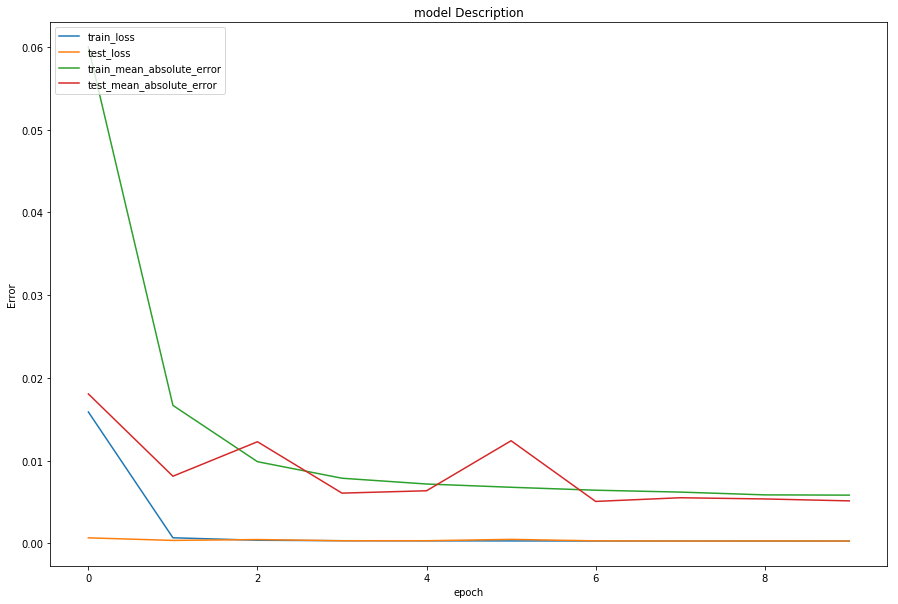

<Figure size 432x288 with 0 Axes>

In [167]:
plot_process(history, 'Linear.png')

## Small evaluation

In [0]:
# Fetching absolute & relative errors
absolute_error = y_scaler.inverse_transform(np.reshape(history.history['val_mean_absolute_error'],(-1,1)))[-1][0]
total_sales = test[['week','item_quantity']].groupby(by = ['week']).agg({'item_quantity':'sum'}).reset_index().iloc[0,1]

In [181]:
print(f"Total absolute error: {absolute_error}\nTotal relative error: {absolute_error/total_sales}%")

Total absolute error: 286.45916748046875
Total relative error: 0.03878407358251675%


## Model saving & Transferring to google cloud

In [0]:
#model.save('Forte_MLP.h5')
model = keras.models.load_model('Forte_MLP.h5')

In [174]:
activate_drive()
!cp Forte_MLP.h5 gdrive/My\ Drive/Colab\ Notebooks/Models/Forte

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Deeper evaluation

In [0]:
# prediction on y_test
y_test_predicted_scaled = model.predict(X_test_scaled)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_scaled)
y_test_predicted = np.round(y_test_predicted)

# prediction on y_train
y_train_predicted_scaled = model.predict(X_train_scaled)
y_train_predicted = y_scaler.inverse_transform(y_train_predicted_scaled)
y_train_predicted = np.round(y_train_predicted)

# Building a predicted train dataframe
train_predicted = train.copy()
train_predicted['item_quantity'] = y_train_predicted

# Building a predicted test dataframe
test_predicted = test.copy()
test_predicted['item_quantity'] = y_test_predicted

# Grouping by week number
train_predicted_grouped = train_predicted[['week','item_quantity']].groupby(['week']).agg({'item_quantity':'sum'}).reset_index().apply(lambda x: x)
test_predicted_grouped = test_predicted[['week','item_quantity']].groupby(['week']).agg({'item_quantity':'sum'}).reset_index().apply(lambda x: x)

In [185]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926 entries, 56198 to 59504
Data columns (total 6 columns):
week             2926 non-null int64
day_of_week      2926 non-null int64
item_id          2926 non-null int64
item_cost        2926 non-null float64
shop_id          2926 non-null int64
item_quantity    2926 non-null float64
dtypes: float64(2), int64(4)
memory usage: 160.0 KB


In [186]:
y_test_predicted.shape

(2926, 1)

In [0]:
# Grouping a datasets with actual datas

train_grouped = train[['week','item_quantity']].groupby(['week']).agg({'item_quantity':'sum'}).reset_index().apply(lambda x: x)
test_grouped = test[['week','item_quantity']].groupby(['week']).agg({'item_quantity':'sum'}).reset_index().apply(lambda x: x)

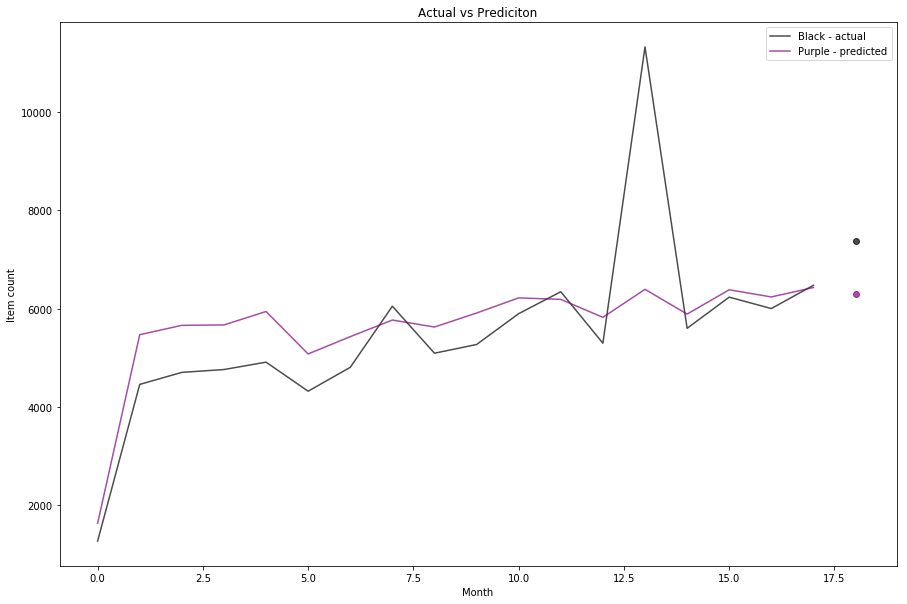

In [189]:
plt.figure(figsize=(15,10))

plt.plot(train_grouped['week'], train_grouped['item_quantity'], color = 'black', alpha = 0.7)
plt.scatter(test_grouped['week'], test_grouped['item_quantity'], color = 'black', alpha = 0.7)

plt.plot(train_predicted_grouped['week'], train_predicted_grouped['item_quantity'], color = 'purple', alpha = 0.7)
plt.scatter(test_predicted_grouped['week'], test_predicted_grouped['item_quantity'], color = 'purple', alpha = 0.7)

plt.title('Actual vs Prediciton')
plt.ylabel('Item count')
plt.xlabel('Month')
plt.legend(['Black - actual', 'Purple - predicted'], loc='upper right')
plt.show()